<a href="https://colab.research.google.com/github/mmarfinetz/evo-optimizer/blob/main/evolutionary_optimizer_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧬 Evolutionary Optimizer Discovery

This notebook evolves novel optimization algorithms using genetic algorithms.

**What it does:**
- Represents optimizers as "genomes" (combinations of mathematical primitives)
- Evaluates fitness by training neural networks on multiple real tasks
- Uses selection, crossover, and mutation to evolve better optimizers

**Requirements:**
- Colab Pro/Pro+ recommended for longer runtimes
- GPU runtime (V100/A100 preferred)
- Google Drive for checkpointing

---

## 1. Setup & Configuration

In [ ]:
# Mount Google Drive for checkpointing
from google.colab import drive
drive.mount('/content/drive')

# Create checkpoint directory
import os
CHECKPOINT_DIR = '/content/drive/MyDrive/evolutionary_optimizer'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print(f"Checkpoints will be saved to: {CHECKPOINT_DIR}")

In [ ]:
# Install dependencies
!pip install torch torchvision torchaudio --quiet
!pip install datasets transformers --quiet  # For language modeling task
!pip install matplotlib pandas seaborn --quiet

In [ ]:
# Configuration - MODIFY THESE FOR YOUR EXPERIMENT
CONFIG = {
    # GA parameters
    'num_generations': 50,
    'population_size': 50,
    'n_elites': 3,
    'tournament_k': 4,

    # Evaluation parameters
    'max_steps_per_task': 500,      # Training steps per task
    'num_seeds': 2,                  # Seeds per evaluation for robustness

    # Tasks to evaluate on (multi-task for generalization)
    'tasks': ['fashion_mnist', 'cifar10', 'mnist'],

    # Checkpointing - CRITICAL for Colab!
    'checkpoint_every': 5,           # Save history plots every N generations
    'checkpoint_every_individual': 5, # Save progress every N individuals (lower = safer)
    'checkpoint_dir': CHECKPOINT_DIR,

    # Reproducibility
    'seed': 42,
}

print("Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")
print()
print("💡 TIP: If Colab keeps disconnecting, lower 'checkpoint_every_individual' to 1-3")
print("        This saves more often but may be slightly slower.")

In [ ]:
# Verify GPU
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    DEVICE = torch.device('cuda')
else:
    print("WARNING: No GPU detected. This will be slow.")
    DEVICE = torch.device('cpu')

## 2. Genome Definition

The genome encodes an optimizer as:
$$\Delta w_t = \eta \cdot \sum_{k=1}^{K} \alpha_k \cdot T_k(g_t, m_t, v_t)$$

Where $T_k$ are primitive operations (gradient, momentum, normalized gradient, etc.)

In [ ]:
from dataclasses import dataclass, field
from typing import List, Optional, Dict, Any, Tuple
from enum import IntEnum
import random
import math
import json
import time
from pathlib import Path
import copy


class PrimitiveType(IntEnum):
    """Catalog of optimizer primitive terms."""
    GRAD = 0           # g_t - raw gradient
    MOMENTUM = 1       # m_t - EMA of gradients
    RMS_NORM = 2       # g_t / (sqrt(v_t) + eps)
    ADAM_TERM = 3      # m_t / (sqrt(v_t) + eps)
    SIGN_GRAD = 4      # sign(g_t)
    SQRT_GRAD = 5      # g_t / (|g_t| + eps) - unit gradient
    NESTEROV = 6       # momentum with lookahead flavor


@dataclass
class Genome:
    """Genome encoding an optimizer algorithm."""
    # Structural genes
    term_types: List[int] = field(default_factory=lambda: [0])
    alphas: List[float] = field(default_factory=lambda: [1.0])

    # Learning rate (log scale)
    lr_log10: float = -3.0

    # EMA coefficients
    beta1: float = 0.9
    beta2: float = 0.999

    # Numerical stability
    eps_log10: float = -8.0

    # Regularization
    wd_log10: float = -4.0

    # Flags
    use_m: bool = True
    use_v: bool = True
    use_bias_correction: bool = True
    use_gradient_clipping: bool = False
    clip_value: float = 1.0

    # Schedule
    use_warmup: bool = False
    warmup_steps: int = 100
    use_cosine_decay: bool = False

    @property
    def K(self) -> int:
        return len(self.term_types)

    @property
    def lr(self) -> float:
        return 10.0 ** self.lr_log10

    @property
    def eps(self) -> float:
        return 10.0 ** self.eps_log10

    @property
    def weight_decay(self) -> float:
        return 10.0 ** self.wd_log10

    def to_dict(self) -> dict:
        return {
            'term_types': self.term_types,
            'alphas': self.alphas,
            'lr_log10': self.lr_log10,
            'beta1': self.beta1,
            'beta2': self.beta2,
            'eps_log10': self.eps_log10,
            'wd_log10': self.wd_log10,
            'use_m': self.use_m,
            'use_v': self.use_v,
            'use_bias_correction': self.use_bias_correction,
            'use_gradient_clipping': self.use_gradient_clipping,
            'clip_value': self.clip_value,
            'use_warmup': self.use_warmup,
            'warmup_steps': self.warmup_steps,
            'use_cosine_decay': self.use_cosine_decay,
        }

    @classmethod
    def from_dict(cls, d: dict) -> 'Genome':
        return cls(**d)

    def __repr__(self) -> str:
        terms = [PrimitiveType(t).name for t in self.term_types]
        return f"Genome(lr={self.lr:.2e}, terms={terms}, alphas={[f'{a:.3f}' for a in self.alphas]})"


print("Genome class defined.")
print(f"Available primitives: {[p.name for p in PrimitiveType]}")

## 3. Optimizer Implementation

In [ ]:
import torch
import torch.nn as nn


def compute_primitive(
    ptype: int,
    g: torch.Tensor,
    m: torch.Tensor,
    v: torch.Tensor,
    eps: float,
) -> torch.Tensor:
    """Compute a primitive optimizer term."""
    if ptype == PrimitiveType.GRAD:
        return g
    elif ptype == PrimitiveType.MOMENTUM:
        return m
    elif ptype == PrimitiveType.RMS_NORM:
        return g / (torch.sqrt(v) + eps)
    elif ptype == PrimitiveType.ADAM_TERM:
        return m / (torch.sqrt(v) + eps)
    elif ptype == PrimitiveType.SIGN_GRAD:
        return torch.sign(g)
    elif ptype == PrimitiveType.SQRT_GRAD:
        return g / (torch.abs(g) + eps)
    elif ptype == PrimitiveType.NESTEROV:
        # Nesterov-style: use momentum with gradient correction
        return m + 0.9 * (g - m)
    else:
        raise ValueError(f"Unknown primitive type: {ptype}")


def init_opt_state(model: nn.Module, genome: Genome) -> Dict[nn.Parameter, Dict[str, Any]]:
    """Initialize optimizer state for all model parameters."""
    state = {}
    for p in model.parameters():
        if p.requires_grad:
            state[p] = {
                'm': torch.zeros_like(p) if genome.use_m else None,
                'v': torch.zeros_like(p) if genome.use_v else None,
                'step': 0,
            }
    return state


def optimizer_step(
    model: nn.Module,
    opt_state: Dict[nn.Parameter, Dict[str, Any]],
    genome: Genome,
    global_step: int = 0,
    total_steps: int = 1000,
) -> None:
    """Perform one optimizer step using the genome's algorithm."""
    base_lr = genome.lr
    eps = genome.eps
    wd = genome.weight_decay

    # Learning rate schedule
    lr = base_lr
    if genome.use_warmup and global_step < genome.warmup_steps:
        lr = base_lr * (global_step + 1) / genome.warmup_steps
    if genome.use_cosine_decay:
        progress = global_step / total_steps
        lr = lr * (0.5 * (1 + math.cos(math.pi * progress)))

    with torch.no_grad():
        for p in model.parameters():
            if not p.requires_grad or p.grad is None:
                continue

            g = p.grad
            state = opt_state[p]
            state['step'] += 1
            t = state['step']

            # Gradient clipping
            if genome.use_gradient_clipping:
                g = torch.clamp(g, -genome.clip_value, genome.clip_value)

            # Weight decay (decoupled)
            if wd > 0:
                p.mul_(1.0 - lr * wd)

            # Update momentum
            m = state['m']
            if genome.use_m and m is not None:
                m.mul_(genome.beta1).add_(g, alpha=1.0 - genome.beta1)
            else:
                m = g

            # Update second moment
            v = state['v']
            if genome.use_v and v is not None:
                v.mul_(genome.beta2).addcmul_(g, g, value=1.0 - genome.beta2)
            else:
                v = g * g

            # Bias correction
            if genome.use_bias_correction:
                m_hat = m / (1.0 - genome.beta1 ** t) if genome.use_m else m
                v_hat = v / (1.0 - genome.beta2 ** t) if genome.use_v else v
            else:
                m_hat = m
                v_hat = v

            # Compute update
            delta = torch.zeros_like(p)
            for ptype, alpha in zip(genome.term_types, genome.alphas):
                term = compute_primitive(ptype, g, m_hat, v_hat, eps)
                delta.add_(term, alpha=alpha)

            # Apply update
            p.add_(delta, alpha=-lr)
            p.grad.zero_()


print("Optimizer implementation ready.")

## 4. Models for Different Tasks

In [ ]:
class SmallCNN(nn.Module):
    """Small CNN for MNIST/FashionMNIST (28x28 grayscale)."""
    def __init__(self, num_classes: int = 10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


class CIFAR10CNN(nn.Module):
    """CNN for CIFAR-10 (32x32 RGB)."""
    def __init__(self, num_classes: int = 10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


class TinyTransformer(nn.Module):
    """Tiny Transformer for character-level language modeling."""
    def __init__(self, vocab_size: int = 256, embed_dim: int = 128,
                 num_heads: int = 4, num_layers: int = 2, seq_len: int = 64):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_embed = nn.Embedding(seq_len, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=embed_dim * 4,
            dropout=0.1, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.head = nn.Linear(embed_dim, vocab_size)
        self.seq_len = seq_len

    def forward(self, x):
        B, T = x.shape
        pos = torch.arange(T, device=x.device).unsqueeze(0).expand(B, T)
        x = self.embed(x) + self.pos_embed(pos)
        # Causal mask
        mask = nn.Transformer.generate_square_subsequent_mask(T, device=x.device)
        x = self.transformer(x, mask=mask, is_causal=True)
        x = self.head(x)
        return x


print("Models defined: SmallCNN, CIFAR10CNN, TinyTransformer")

## 5. Data Loading (Real Datasets)

In [ ]:
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, transforms
import numpy as np


class CharDataset(Dataset):
    """Character-level dataset from text."""
    def __init__(self, text: str, seq_len: int = 64):
        self.seq_len = seq_len
        # Use raw bytes (0-255)
        self.data = torch.tensor([ord(c) % 256 for c in text], dtype=torch.long)

    def __len__(self):
        return max(0, len(self.data) - self.seq_len - 1)

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_len]
        y = self.data[idx + 1:idx + self.seq_len + 1]
        return x, y


def load_task_data(task_name: str, train_samples: int = 10000, batch_size: int = 128):
    """
    Load real dataset for a task.

    Returns: (train_loader, test_loader, model_fn)
    """
    if task_name == 'mnist':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
        test_data = datasets.MNIST('./data', train=False, download=True, transform=transform)
        model_fn = lambda: SmallCNN(num_classes=10)

    elif task_name == 'fashion_mnist':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.2860,), (0.3530,))
        ])
        train_data = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
        test_data = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)
        model_fn = lambda: SmallCNN(num_classes=10)

    elif task_name == 'cifar10':
        transform_train = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
        ])
        train_data = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
        test_data = datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)
        model_fn = lambda: CIFAR10CNN(num_classes=10)

    elif task_name == 'language':
        # Download a real text corpus
        import urllib.request
        print("  Downloading Shakespeare dataset...")
        url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
        text_path = './data/shakespeare.txt'
        os.makedirs('./data', exist_ok=True)
        if not os.path.exists(text_path):
            urllib.request.urlretrieve(url, text_path)
        with open(text_path, 'r') as f:
            text = f.read()
        print(f"  Loaded {len(text):,} characters")

        # Split into train/test
        split = int(len(text) * 0.9)
        train_data = CharDataset(text[:split], seq_len=64)
        test_data = CharDataset(text[split:], seq_len=64)
        model_fn = lambda: TinyTransformer(vocab_size=256, embed_dim=128, num_heads=4, num_layers=2)

        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)
        return train_loader, test_loader, model_fn, 'lm'  # language modeling

    else:
        raise ValueError(f"Unknown task: {task_name}")

    # Subset for faster evaluation
    if train_samples and train_samples < len(train_data):
        indices = torch.randperm(len(train_data))[:train_samples].tolist()
        train_data = Subset(train_data, indices)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader, model_fn, 'classification'


# Preload all task data
print("Loading datasets...")
TASK_DATA = {}
for task in CONFIG['tasks']:
    print(f"  Loading {task}...")
    TASK_DATA[task] = load_task_data(task, train_samples=15000)
print("All datasets loaded.")

## 6. Fitness Evaluation

In [ ]:
def evaluate_genome_on_task(
    genome: Genome,
    train_loader: DataLoader,
    test_loader: DataLoader,
    model_fn,
    task_type: str,
    device: torch.device,
    max_steps: int = 500,
    seed: int = 0,
) -> Tuple[float, dict]:
    """Evaluate genome on a single task."""
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = model_fn().to(device)
    opt_state = init_opt_state(model, genome)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    diverged = False

    # Training
    model.train()
    steps = 0
    for epoch in range(100):
        for batch in train_loader:
            if task_type == 'classification':
                x, y = batch
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = criterion(logits, y)
            else:  # language modeling
                x, y = batch
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))

            # Check divergence
            if math.isnan(loss.item()) or math.isinf(loss.item()) or loss.item() > 50:
                diverged = True
                break

            train_losses.append(loss.item())
            loss.backward()

            try:
                optimizer_step(model, opt_state, genome, global_step=steps, total_steps=max_steps)
            except RuntimeError:
                diverged = True
                break

            steps += 1
            if steps >= max_steps:
                break

        if steps >= max_steps or diverged:
            break

    # Evaluation
    val_metric = 0.0
    if not diverged:
        model.eval()
        if task_type == 'classification':
            correct, total = 0, 0
            with torch.no_grad():
                for x, y in test_loader:
                    x, y = x.to(device), y.to(device)
                    logits = model(x)
                    preds = logits.argmax(dim=1)
                    correct += (preds == y).sum().item()
                    total += y.size(0)
            val_metric = correct / total if total > 0 else 0
        else:  # language modeling - use negative perplexity
            total_loss, total_tokens = 0, 0
            with torch.no_grad():
                for x, y in test_loader:
                    x, y = x.to(device), y.to(device)
                    logits = model(x)
                    loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
                    total_loss += loss.item() * y.numel()
                    total_tokens += y.numel()
                    if total_tokens > 50000:  # limit eval
                        break
            perplexity = math.exp(total_loss / total_tokens) if total_tokens > 0 else float('inf')
            # Convert to 0-1 scale (lower perplexity = better)
            val_metric = max(0, 1.0 - perplexity / 100)

    # Compute fitness
    if diverged:
        fitness = -1.0
    else:
        fitness = val_metric
        if len(train_losses) > 0:
            avg_loss = sum(train_losses[-50:]) / min(50, len(train_losses))
            fitness += 0.05 * max(0, 1.0 - avg_loss)

    metrics = {
        'val_metric': val_metric,
        'diverged': diverged,
        'steps': steps,
        'final_loss': train_losses[-1] if train_losses else float('inf'),
    }

    return fitness, metrics


def evaluate_genome_multi_task(
    genome: Genome,
    task_data: dict,
    device: torch.device,
    max_steps: int = 500,
    num_seeds: int = 2,
) -> Tuple[float, dict]:
    """Evaluate genome across multiple tasks and seeds."""
    all_fitnesses = []
    task_metrics = {}

    for task_name, (train_loader, test_loader, model_fn, task_type) in task_data.items():
        task_fits = []
        for seed in range(num_seeds):
            fitness, metrics = evaluate_genome_on_task(
                genome, train_loader, test_loader, model_fn, task_type,
                device, max_steps=max_steps, seed=seed
            )
            task_fits.append(fitness)

        avg_fit = sum(task_fits) / len(task_fits)
        all_fitnesses.append(avg_fit)
        task_metrics[task_name] = {
            'mean_fitness': avg_fit,
            'all_fitness': task_fits,
        }

    # Overall fitness: mean across tasks (encourages generalization)
    overall_fitness = sum(all_fitnesses) / len(all_fitnesses)

    return overall_fitness, task_metrics


print("Fitness evaluation functions ready.")

## 7. Genetic Algorithm Operators

In [ ]:
# === SELECTION ===

def tournament_select(population: List[Genome], fitnesses: List[float], k: int = 3) -> Genome:
    """Tournament selection."""
    indices = random.sample(range(len(population)), min(k, len(population)))
    best_idx = max(indices, key=lambda i: fitnesses[i])
    return population[best_idx]


def select_elites(population: List[Genome], fitnesses: List[float], n: int = 2) -> List[Genome]:
    """Select top n individuals."""
    sorted_idx = sorted(range(len(population)), key=lambda i: fitnesses[i], reverse=True)
    return [copy.deepcopy(population[i]) for i in sorted_idx[:n]]


# === CROSSOVER ===

def crossover(parent_a: Genome, parent_b: Genome) -> Genome:
    """Create child by combining two parents."""
    def pick(a, b):
        return a if random.random() < 0.5 else b

    # Structural crossover for terms
    if len(parent_a.term_types) > 1:
        point_a = random.randint(1, len(parent_a.term_types))
    else:
        point_a = 1
    point_b = random.randint(0, max(0, len(parent_b.term_types) - 1))

    child_terms = parent_a.term_types[:point_a] + parent_b.term_types[point_b:]
    child_alphas = parent_a.alphas[:point_a] + parent_b.alphas[point_b:]

    # Limit terms
    if len(child_terms) > 4:
        child_terms = child_terms[:4]
        child_alphas = child_alphas[:4]
    if len(child_terms) == 0:
        child_terms = [0]
        child_alphas = [1.0]

    return Genome(
        term_types=child_terms,
        alphas=child_alphas,
        lr_log10=pick(parent_a.lr_log10, parent_b.lr_log10),
        beta1=pick(parent_a.beta1, parent_b.beta1),
        beta2=pick(parent_a.beta2, parent_b.beta2),
        eps_log10=pick(parent_a.eps_log10, parent_b.eps_log10),
        wd_log10=pick(parent_a.wd_log10, parent_b.wd_log10),
        use_m=pick(parent_a.use_m, parent_b.use_m),
        use_v=pick(parent_a.use_v, parent_b.use_v),
        use_bias_correction=pick(parent_a.use_bias_correction, parent_b.use_bias_correction),
        use_gradient_clipping=pick(parent_a.use_gradient_clipping, parent_b.use_gradient_clipping),
        clip_value=pick(parent_a.clip_value, parent_b.clip_value),
        use_warmup=pick(parent_a.use_warmup, parent_b.use_warmup),
        warmup_steps=pick(parent_a.warmup_steps, parent_b.warmup_steps),
        use_cosine_decay=pick(parent_a.use_cosine_decay, parent_b.use_cosine_decay),
    )


# === MUTATION ===

def mutate(genome: Genome, generation: int = 0, max_gen: int = 50) -> Genome:
    """Apply mutations with adaptive rates."""
    # Adaptive decay
    decay = 1.0 - 0.5 * (generation / max_gen)
    p_num = 0.35 * decay
    p_struct = 0.15 * decay
    p_flag = 0.1 * decay
    sigma = 0.3 * decay

    term_types = list(genome.term_types)
    alphas = list(genome.alphas)
    lr_log10 = genome.lr_log10
    beta1 = genome.beta1
    beta2 = genome.beta2
    eps_log10 = genome.eps_log10
    wd_log10 = genome.wd_log10
    use_m = genome.use_m
    use_v = genome.use_v
    use_bias_correction = genome.use_bias_correction
    use_gradient_clipping = genome.use_gradient_clipping
    clip_value = genome.clip_value
    use_warmup = genome.use_warmup
    warmup_steps = genome.warmup_steps
    use_cosine_decay = genome.use_cosine_decay

    # Numeric mutations
    if random.random() < p_num:
        lr_log10 = max(-5, min(-1, lr_log10 + random.gauss(0, sigma)))
    if random.random() < p_num:
        beta1 = max(0, min(0.999, beta1 + random.gauss(0, sigma * 0.2)))
    if random.random() < p_num:
        beta2 = max(0, min(0.9999, beta2 + random.gauss(0, sigma * 0.1)))
    if random.random() < p_num:
        eps_log10 = max(-10, min(-4, eps_log10 + random.gauss(0, sigma)))
    if random.random() < p_num:
        wd_log10 = max(-6, min(-2, wd_log10 + random.gauss(0, sigma)))

    # Alpha mutations
    for i in range(len(alphas)):
        if random.random() < p_num:
            alphas[i] = max(-5, min(5, alphas[i] * math.exp(random.gauss(0, sigma))))

    # Structural mutations
    if random.random() < p_struct:
        op = random.choice(['add', 'remove', 'change'])
        if op == 'add' and len(term_types) < 4:
            term_types.append(random.randint(0, len(PrimitiveType) - 1))
            alphas.append(random.uniform(-1, 1))
        elif op == 'remove' and len(term_types) > 1:
            idx = random.randint(0, len(term_types) - 1)
            term_types.pop(idx)
            alphas.pop(idx)
        elif op == 'change' and len(term_types) > 0:
            idx = random.randint(0, len(term_types) - 1)
            term_types[idx] = random.randint(0, len(PrimitiveType) - 1)

    # Flag mutations
    if random.random() < p_flag:
        use_m = not use_m
    if random.random() < p_flag:
        use_v = not use_v
    if random.random() < p_flag:
        use_bias_correction = not use_bias_correction
    if random.random() < p_flag:
        use_gradient_clipping = not use_gradient_clipping
    if random.random() < p_flag:
        use_warmup = not use_warmup
    if random.random() < p_flag:
        use_cosine_decay = not use_cosine_decay

    return Genome(
        term_types=term_types,
        alphas=alphas,
        lr_log10=lr_log10,
        beta1=beta1,
        beta2=beta2,
        eps_log10=eps_log10,
        wd_log10=wd_log10,
        use_m=use_m,
        use_v=use_v,
        use_bias_correction=use_bias_correction,
        use_gradient_clipping=use_gradient_clipping,
        clip_value=clip_value,
        use_warmup=use_warmup,
        warmup_steps=warmup_steps,
        use_cosine_decay=use_cosine_decay,
    )


print("GA operators ready.")

## 8. Population Initialization

In [ ]:
def sgd_genome() -> Genome:
    return Genome(
        term_types=[PrimitiveType.MOMENTUM],
        alphas=[1.0],
        lr_log10=-2.0,
        beta1=0.9,
        use_m=True,
        use_v=False,
        use_bias_correction=False,
    )

def adam_genome() -> Genome:
    return Genome(
        term_types=[PrimitiveType.ADAM_TERM],
        alphas=[1.0],
        lr_log10=-3.0,
        beta1=0.9,
        beta2=0.999,
        use_m=True,
        use_v=True,
        use_bias_correction=True,
    )

def adamw_genome() -> Genome:
    g = adam_genome()
    g.wd_log10 = -2.0  # stronger weight decay
    return g

def rmsprop_genome() -> Genome:
    return Genome(
        term_types=[PrimitiveType.RMS_NORM],
        alphas=[1.0],
        lr_log10=-3.0,
        beta2=0.99,
        use_m=False,
        use_v=True,
        use_bias_correction=False,
    )

def random_genome() -> Genome:
    k = random.randint(1, 3)
    return Genome(
        term_types=[random.randint(0, len(PrimitiveType) - 1) for _ in range(k)],
        alphas=[random.uniform(-1, 1) for _ in range(k)],
        lr_log10=random.uniform(-4, -2),
        beta1=random.uniform(0.5, 0.99),
        beta2=random.uniform(0.9, 0.9999),
        eps_log10=random.uniform(-9, -6),
        wd_log10=random.uniform(-5, -3),
        use_m=random.random() < 0.7,
        use_v=random.random() < 0.7,
        use_bias_correction=random.random() < 0.6,
        use_gradient_clipping=random.random() < 0.2,
        clip_value=random.uniform(0.5, 2.0),
        use_warmup=random.random() < 0.3,
        warmup_steps=random.randint(50, 200),
        use_cosine_decay=random.random() < 0.3,
    )

def init_population(size: int) -> List[Genome]:
    """Initialize population with known seeds + random."""
    pop = [
        sgd_genome(),
        adam_genome(),
        adamw_genome(),
        rmsprop_genome(),
    ]
    while len(pop) < size:
        pop.append(random_genome())
    return pop


print("Population initialization ready.")
print(f"Seed optimizers: SGD, Adam, AdamW, RMSProp")

## 9. Checkpointing

In [ ]:
def save_checkpoint(filepath: str, generation: int, population: List[Genome],
                    fitnesses: List[float], history: dict, best_genome: Genome,
                    partial_gen_state: dict = None):
    """Save checkpoint to file with optional partial generation state."""
    data = {
        'generation': generation,
        'population': [g.to_dict() for g in population],
        'fitnesses': fitnesses,
        'history': history,
        'best_genome': best_genome.to_dict() if best_genome else None,
        'partial_gen_state': partial_gen_state,  # For mid-generation resume
    }
    # Write to temp file first, then rename (atomic operation)
    temp_path = filepath + '.tmp'
    with open(temp_path, 'w') as f:
        json.dump(data, f, indent=2)
    os.replace(temp_path, filepath)
    print(f"  💾 Checkpoint saved: gen {generation}, {len([f for f in fitnesses if f is not None])} evaluated")


def load_checkpoint(filepath: str) -> Optional[dict]:
    """Load checkpoint from file."""
    if not os.path.exists(filepath):
        return None
    try:
        with open(filepath, 'r') as f:
            data = json.load(f)
        data['population'] = [Genome.from_dict(g) for g in data['population']]
        if data['best_genome']:
            data['best_genome'] = Genome.from_dict(data['best_genome'])
        return data
    except (json.JSONDecodeError, KeyError) as e:
        print(f"  ⚠️ Warning: Could not load checkpoint: {e}")
        return None


print("Checkpointing ready (with mid-generation support).")

## 10. Main Evolution Loop

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


def run_evolution(config: dict, task_data: dict, device: torch.device,
                  resume_from: str = None) -> Tuple[Genome, dict]:
    """
    Main evolution loop with ROBUST checkpointing.

    Saves progress after EVERY genome evaluation so you never lose work
    if Colab disconnects.
    """
    random.seed(config['seed'])
    torch.manual_seed(config['seed'])
    np.random.seed(config['seed'])

    checkpoint_path = os.path.join(config['checkpoint_dir'], 'checkpoint.json')

    # How often to save (every N individuals). Lower = safer but slower
    CHECKPOINT_EVERY_N_INDIVIDUALS = config.get('checkpoint_every_individual', 5)

    # Initialize state
    start_gen = 0
    start_individual = 0
    partial_fitnesses = []
    partial_task_metrics = []
    history = {'best_fitness': [], 'avg_fitness': [], 'task_breakdown': []}
    best_genome_ever = None
    best_fitness_ever = -float('inf')

    # Try to resume from checkpoint
    if resume_from and os.path.exists(resume_from):
        print(f"📂 Found checkpoint: {resume_from}")
        ckpt = load_checkpoint(resume_from)
        if ckpt:
            # Check if we have partial generation state (mid-generation resume)
            partial = ckpt.get('partial_gen_state')

            if partial and partial.get('fitnesses'):
                # Resume mid-generation!
                start_gen = partial['generation']
                start_individual = len([f for f in partial['fitnesses'] if f is not None])
                partial_fitnesses = partial['fitnesses']
                partial_task_metrics = partial.get('task_metrics', [None] * len(partial_fitnesses))
                population = ckpt['population']
                history = ckpt['history']
                best_genome_ever = ckpt['best_genome']
                best_fitness_ever = max([f for f in ckpt['fitnesses'] if f is not None], default=-float('inf'))

                print(f"  ⚡ RESUMING MID-GENERATION!")
                print(f"  📍 Generation {start_gen + 1}, Individual {start_individual + 1}/{len(population)}")
                print(f"  🏆 Best fitness so far: {best_fitness_ever:.4f}")
            else:
                # Resume from completed generation
                start_gen = ckpt['generation'] + 1
                population = ckpt['population']
                history = ckpt['history']
                best_genome_ever = ckpt['best_genome']
                best_fitness_ever = max([f for f in ckpt['fitnesses'] if f is not None], default=-float('inf'))

                print(f"  ✅ Resuming from generation {start_gen}")
                print(f"  🏆 Best fitness: {best_fitness_ever:.4f}")
        else:
            population = init_population(config['population_size'])
    else:
        print("🆕 Starting fresh evolution.")
        population = init_population(config['population_size'])

    # Calculate time estimates
    total_individuals = config['num_generations'] * config['population_size']
    completed_individuals = start_gen * config['population_size'] + start_individual

    print(f"\n{'='*60}")
    print(f"🧬 EVOLUTIONARY OPTIMIZER DISCOVERY")
    print(f"{'='*60}")
    print(f"  Population:     {config['population_size']}")
    print(f"  Generations:    {config['num_generations']}")
    print(f"  Tasks:          {', '.join(config['tasks'])}")
    print(f"  Steps/task:     {config['max_steps_per_task']}")
    print(f"  Seeds/eval:     {config['num_seeds']}")
    print(f"  Checkpoint:     Every {CHECKPOINT_EVERY_N_INDIVIDUALS} individuals")
    print(f"{'='*60}")

    if completed_individuals > 0:
        print(f"  📊 Progress:    {completed_individuals}/{total_individuals} evaluations done")
    print()

    eval_times = []  # Track evaluation times for estimates

    for gen in range(start_gen, config['num_generations']):
        gen_start = time.time()
        print(f"\n{'─'*60}")
        print(f"🔬 Generation {gen + 1}/{config['num_generations']}")
        print(f"{'─'*60}")

        # Initialize or resume fitnesses for this generation
        if gen == start_gen and partial_fitnesses:
            fitnesses = partial_fitnesses
            all_task_metrics = partial_task_metrics
        else:
            fitnesses = [None] * len(population)
            all_task_metrics = [None] * len(population)
            start_individual = 0

        # Evaluate individuals (resumable!)
        for i in range(start_individual, len(population)):
            ind_start = time.time()
            genome = population[i]

            try:
                fitness, task_metrics = evaluate_genome_multi_task(
                    genome, task_data, device,
                    max_steps=config['max_steps_per_task'],
                    num_seeds=config['num_seeds']
                )
            except Exception as e:
                print(f"    ⚠️ Error evaluating genome {i}: {e}")
                fitness = -1.0
                task_metrics = {}

            fitnesses[i] = fitness
            all_task_metrics[i] = task_metrics

            eval_time = time.time() - ind_start
            eval_times.append(eval_time)

            # Progress display
            remaining = (config['num_generations'] - gen - 1) * len(population) + (len(population) - i - 1)
            if len(eval_times) > 3:
                avg_time = sum(eval_times[-20:]) / min(20, len(eval_times))
                eta = timedelta(seconds=int(remaining * avg_time))
                eta_str = f"ETA: {eta}"
            else:
                eta_str = "calculating..."

            bar_len = 20
            progress = (i + 1) / len(population)
            filled = int(bar_len * progress)
            bar = '█' * filled + '░' * (bar_len - filled)

            print(f"\r  [{bar}] {i+1}/{len(population)} | fit={fitness:.3f} | {eta_str}    ", end='', flush=True)

            # Update best
            if fitness > best_fitness_ever:
                best_fitness_ever = fitness
                best_genome_ever = copy.deepcopy(genome)
                print(f"\n    🌟 NEW BEST: {fitness:.4f}")

            # Checkpoint periodically
            if (i + 1) % CHECKPOINT_EVERY_N_INDIVIDUALS == 0 or i == len(population) - 1:
                partial_state = {
                    'generation': gen,
                    'fitnesses': fitnesses,
                    'task_metrics': all_task_metrics,
                }
                save_checkpoint(
                    checkpoint_path, gen, population,
                    [f if f is not None else -999 for f in fitnesses],  # placeholder for None
                    history, best_genome_ever,
                    partial_gen_state=partial_state
                )

        print()  # newline after progress bar

        # Reset for next generation
        start_individual = 0
        partial_fitnesses = []
        partial_task_metrics = []

        # Generation statistics
        valid_fitnesses = [f for f in fitnesses if f is not None and f > -999]
        best_fitness = max(valid_fitnesses) if valid_fitnesses else -1
        avg_fitness = sum(valid_fitnesses) / len(valid_fitnesses) if valid_fitnesses else -1
        best_idx = fitnesses.index(best_fitness) if best_fitness in fitnesses else 0

        history['best_fitness'].append(best_fitness)
        history['avg_fitness'].append(avg_fitness)
        history['task_breakdown'].append(all_task_metrics[best_idx] if all_task_metrics[best_idx] else {})

        gen_time = time.time() - gen_start

        print(f"\n  📈 Generation {gen + 1} Summary ({gen_time:.1f}s):")
        print(f"     Best:  {best_fitness:.4f}  |  Avg: {avg_fitness:.4f}")
        print(f"     Best genome: {population[best_idx]}")

        # Show task breakdown
        if all_task_metrics[best_idx]:
            breakdown = " | ".join([f"{k}: {v['mean_fitness']:.3f}" for k, v in all_task_metrics[best_idx].items()])
            print(f"     Tasks: {breakdown}")

        # Term distribution
        term_counts = {}
        for g in population:
            for t in g.term_types:
                name = PrimitiveType(t).name
                term_counts[name] = term_counts.get(name, 0) + 1
        top_terms = sorted(term_counts.items(), key=lambda x: -x[1])[:5]
        print(f"     Popular terms: {dict(top_terms)}")

        # Save completed generation (clear partial state)
        save_checkpoint(checkpoint_path, gen, population, fitnesses, history, best_genome_ever,
                       partial_gen_state=None)

        # Don't evolve after last generation
        if gen == config['num_generations'] - 1:
            break

        # Selection & reproduction
        print(f"\n  🧬 Creating next generation...")
        new_population = select_elites(population, fitnesses, config['n_elites'])

        while len(new_population) < config['population_size']:
            p1 = tournament_select(population, fitnesses, config['tournament_k'])
            p2 = tournament_select(population, fitnesses, config['tournament_k'])
            child = crossover(p1, p2)
            child = mutate(child, generation=gen, max_gen=config['num_generations'])
            new_population.append(child)

        population = new_population

    print(f"\n{'='*60}")
    print("🎉 EVOLUTION COMPLETE!")
    print(f"{'='*60}")
    print(f"\n🏆 Best Genome Found:")
    print(f"   {best_genome_ever}")
    print(f"   Fitness: {best_fitness_ever:.4f}")

    # Total time
    if eval_times:
        total_time = sum(eval_times)
        print(f"\n⏱️  Total evaluation time: {timedelta(seconds=int(total_time))}")

    return best_genome_ever, history


print("✅ Evolution loop ready (with robust mid-generation checkpointing).")

## 11. Run Evolution!

In [ ]:
# Check for existing checkpoint to resume
checkpoint_path = os.path.join(CONFIG['checkpoint_dir'], 'checkpoint.json')
resume_path = checkpoint_path if os.path.exists(checkpoint_path) else None

if resume_path:
    print("="*60)
    print("📂 EXISTING CHECKPOINT FOUND!")
    print("="*60)
    print(f"Location: {resume_path}")
    print()
    print("The evolution will AUTOMATICALLY resume from where it stopped.")
    print("If Colab disconnected mid-generation, it will pick up exactly there.")
    print()
    print("To START FRESH instead, delete the checkpoint:")
    print(f"  !rm '{checkpoint_path}'")
    print("="*60)
else:
    print("🆕 No checkpoint found. Starting fresh evolution.")

print()
print("🚀 Starting evolution... (safe to disconnect - progress is saved!)")
print()

# RUN EVOLUTION
best_genome, history = run_evolution(
    CONFIG,
    TASK_DATA,
    DEVICE,
    resume_from=resume_path
)

📂 EXISTING CHECKPOINT FOUND!
Location: /content/drive/MyDrive/evolutionary_optimizer/checkpoint.json

The evolution will AUTOMATICALLY resume from where it stopped.
If Colab disconnected mid-generation, it will pick up exactly there.

To START FRESH instead, delete the checkpoint:
  !rm '/content/drive/MyDrive/evolutionary_optimizer/checkpoint.json'

🚀 Starting evolution... (safe to disconnect - progress is saved!)

📂 Found checkpoint: /content/drive/MyDrive/evolutionary_optimizer/checkpoint.json
  ⚡ RESUMING MID-GENERATION!
  📍 Generation 35, Individual 26/50
  🏆 Best fitness so far: 0.8778

🧬 EVOLUTIONARY OPTIMIZER DISCOVERY
  Population:     50
  Generations:    50
  Tasks:          fashion_mnist, cifar10, mnist
  Steps/task:     500
  Seeds/eval:     2
  Checkpoint:     Every 5 individuals
  📊 Progress:    1725/2500 evaluations done


────────────────────────────────────────────────────────────
🔬 Generation 35/50
────────────────────────────────────────────────────────────
  [█████

## 12. Visualization & Analysis

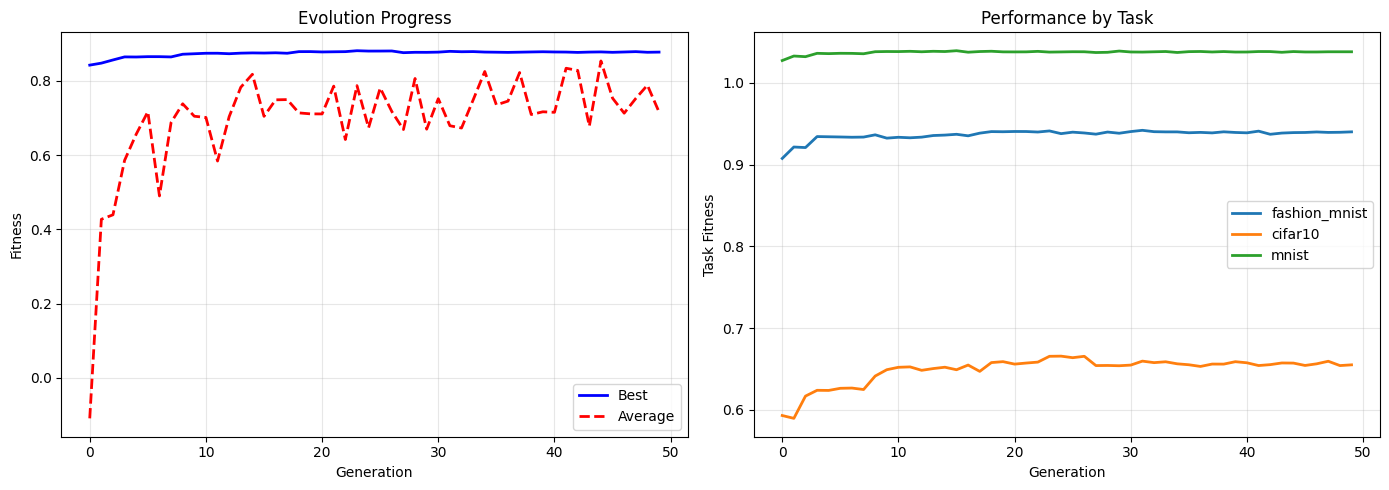

In [ ]:
# Plot evolution history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Fitness over generations
ax1 = axes[0]
ax1.plot(history['best_fitness'], 'b-', label='Best', linewidth=2)
ax1.plot(history['avg_fitness'], 'r--', label='Average', linewidth=2)
ax1.set_xlabel('Generation')
ax1.set_ylabel('Fitness')
ax1.set_title('Evolution Progress')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Task-specific performance
ax2 = axes[1]
task_names = list(history['task_breakdown'][0].keys())
for task in task_names:
    task_history = [h[task]['mean_fitness'] for h in history['task_breakdown']]
    ax2.plot(task_history, label=task, linewidth=2)
ax2.set_xlabel('Generation')
ax2.set_ylabel('Task Fitness')
ax2.set_title('Performance by Task')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['checkpoint_dir'], 'evolution_progress.png'), dpi=150)
plt.show()

In [ ]:
# Display best genome details
print("Best Evolved Optimizer:")
print("=" * 50)
print(f"Learning Rate: {best_genome.lr:.6f}")
print(f"Beta1: {best_genome.beta1:.4f}")
print(f"Beta2: {best_genome.beta2:.5f}")
print(f"Epsilon: {best_genome.eps:.2e}")
print(f"Weight Decay: {best_genome.weight_decay:.2e}")
print(f"")
print(f"Update Rule Components:")
for i, (t, a) in enumerate(zip(best_genome.term_types, best_genome.alphas)):
    print(f"  {i+1}. {PrimitiveType(t).name} × {a:.4f}")
print(f"")
print(f"Flags:")
print(f"  Use momentum: {best_genome.use_m}")
print(f"  Use 2nd moment: {best_genome.use_v}")
print(f"  Bias correction: {best_genome.use_bias_correction}")
print(f"  Gradient clipping: {best_genome.use_gradient_clipping}")
print(f"  Warmup: {best_genome.use_warmup}")
print(f"  Cosine decay: {best_genome.use_cosine_decay}")

Best Evolved Optimizer:
Learning Rate: 0.001203
Beta1: 0.8553
Beta2: 0.93576
Epsilon: 5.44e-09
Weight Decay: 9.74e-04

Update Rule Components:
  1. SIGN_GRAD × 0.4121
  2. SIGN_GRAD × 0.3224
  3. ADAM_TERM × 2.0030
  4. ADAM_TERM × 1.6322

Flags:
  Use momentum: True
  Use 2nd moment: True
  Bias correction: False
  Gradient clipping: False
  Warmup: True
  Cosine decay: True


## 13. Compare with Baselines

In [ ]:
# Thorough comparison with baselines
print("Comparing evolved optimizer with baselines...")
print("Using longer training (1000 steps) for fair comparison.\n")

comparison_steps = 1000
comparison_seeds = 3

baselines = {
    'SGD (momentum)': sgd_genome(),
    'Adam': adam_genome(),
    'AdamW': adamw_genome(),
    'RMSProp': rmsprop_genome(),
    'EVOLVED': best_genome,
}

results = {}
for name, genome in baselines.items():
    print(f"Evaluating {name}...")
    fitness, task_metrics = evaluate_genome_multi_task(
        genome, TASK_DATA, DEVICE,
        max_steps=comparison_steps,
        num_seeds=comparison_seeds
    )
    results[name] = {
        'overall': fitness,
        'tasks': task_metrics
    }
    print(f"  Overall: {fitness:.4f}")
    for task, metrics in task_metrics.items():
        print(f"    {task}: {metrics['mean_fitness']:.4f}")
    print()

Comparing evolved optimizer with baselines...
Using longer training (1000 steps) for fair comparison.

Evaluating SGD (momentum)...
  Overall: 0.7617
    fashion_mnist: 0.8234
    cifar10: 0.4739
    mnist: 0.9877

Evaluating Adam...
  Overall: 0.8685
    fashion_mnist: 0.9313
    cifar10: 0.6396
    mnist: 1.0347

Evaluating AdamW...
  Overall: 0.8720
    fashion_mnist: 0.9306
    cifar10: 0.6497
    mnist: 1.0356

Evaluating RMSProp...
  Overall: 0.6760
    fashion_mnist: 0.9289
    cifar10: 0.0639
    mnist: 1.0352

Evaluating EVOLVED...
  Overall: 0.8979
    fashion_mnist: 0.9508
    cifar10: 0.7035
    mnist: 1.0395



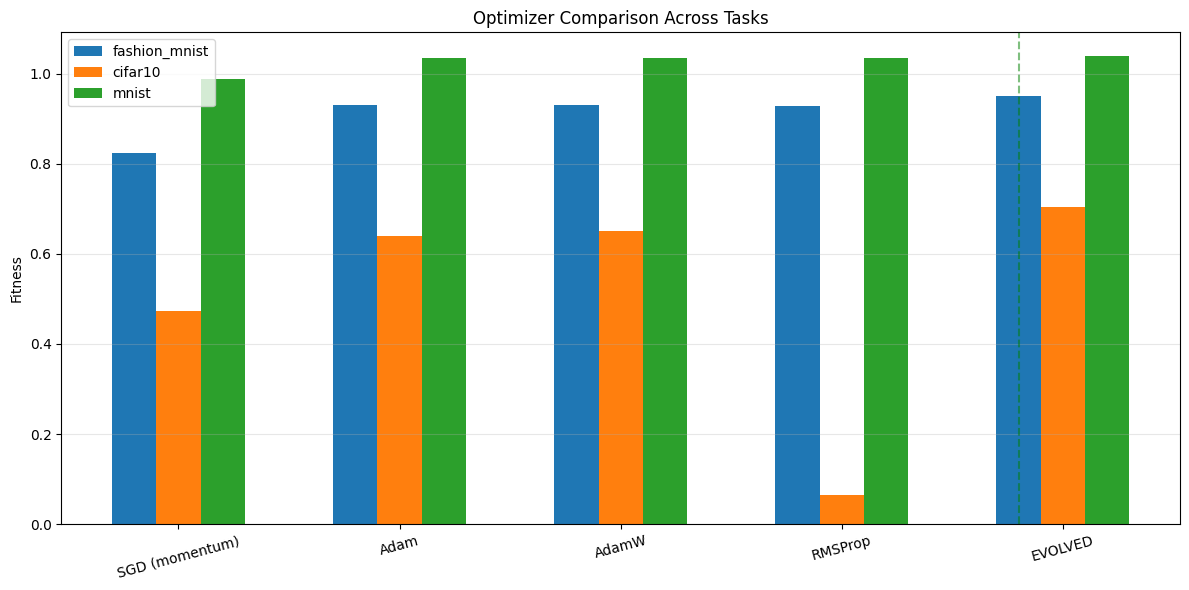


Summary:
--------------------------------------------------
     Optimizer  Overall  fashion_mnist  cifar10    mnist
SGD (momentum) 0.761685       0.823445 0.473933 0.987676
          Adam 0.868526       0.931275 0.639600 1.034705
         AdamW 0.871965       0.930636 0.649700 1.035559
       RMSProp 0.676037       0.928933 0.063933 1.035246
       EVOLVED 0.897925       0.950789 0.703457 1.039527


In [ ]:
# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))

names = list(results.keys())
tasks = list(results[names[0]]['tasks'].keys())
x = np.arange(len(names))
width = 0.2

for i, task in enumerate(tasks):
    values = [results[n]['tasks'][task]['mean_fitness'] for n in names]
    ax.bar(x + i * width, values, width, label=task)

ax.set_ylabel('Fitness')
ax.set_title('Optimizer Comparison Across Tasks')
ax.set_xticks(x + width * (len(tasks) - 1) / 2)
ax.set_xticklabels(names, rotation=15)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Highlight evolved
evolved_idx = names.index('EVOLVED')
ax.axvline(x=evolved_idx, color='green', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['checkpoint_dir'], 'comparison.png'), dpi=150)
plt.show()

# Summary table
print("\nSummary:")
print("-" * 50)
summary_data = []
for name in names:
    row = {'Optimizer': name, 'Overall': results[name]['overall']}
    for task in tasks:
        row[task] = results[name]['tasks'][task]['mean_fitness']
    summary_data.append(row)
df = pd.DataFrame(summary_data)
print(df.to_string(index=False))

## 14. Export Best Genome

In [ ]:
# Save final results
final_results = {
    'best_genome': best_genome.to_dict(),
    'config': CONFIG,
    'history': history,
    'comparison': {k: {'overall': v['overall']} for k, v in results.items()},
}

results_path = os.path.join(CONFIG['checkpoint_dir'], 'final_results.json')
with open(results_path, 'w') as f:
    json.dump(final_results, f, indent=2)

print(f"Results saved to: {results_path}")
print(f"\nTo use this optimizer in your own code:")
print(f"")
print(f"genome = Genome(")
print(f"    term_types={best_genome.term_types},")
print(f"    alphas={best_genome.alphas},")
print(f"    lr_log10={best_genome.lr_log10},")
print(f"    beta1={best_genome.beta1},")
print(f"    beta2={best_genome.beta2},")
print(f"    eps_log10={best_genome.eps_log10},")
print(f"    wd_log10={best_genome.wd_log10},")
print(f"    use_m={best_genome.use_m},")
print(f"    use_v={best_genome.use_v},")
print(f"    use_bias_correction={best_genome.use_bias_correction},")
print(f")")

Results saved to: /content/drive/MyDrive/evolutionary_optimizer/final_results.json

To use this optimizer in your own code:

genome = Genome(
    term_types=[4, 4, 3, 3],
    alphas=[0.41205802174892475, 0.32238621456272765, 2.0030004279455267, 1.6322011630060542],
    lr_log10=-2.9198932483267144,
    beta1=0.8553020861538518,
    beta2=0.9357561078635277,
    eps_log10=-8.26423960220415,
    wd_log10=-3.0112238437153316,
    use_m=True,
    use_v=True,
    use_bias_correction=False,
)
